In [5]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate, constants, signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os

In [6]:
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
 fig_folder='D:\\OneDrive - NERC\\OneDrive - NERC\\SEASTAR\\PM WP4000\\figures\\'

# L1a to L1b processing

In [73]:
version = 'FINAL'
flight = '20220517'
file_paths = ss.utils.readers._set_file_paths()
oscar_path = os.path.join(file_paths['oscar_path'], version, flight, 'matlab-pre-processed','')
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

#DAR_tracks={
#    'Track_2' : 1,
#    }
DAR_tracks={
    'Track_1' : 3,
    'Track_2' : 4,
    'Track_1b' :5
    }
#
# L1a variables to be passed to L1b dataset
vars_to_keep = [
        'LatImage',
        'LonImage',
        'IncidenceAngleImage',
        'LookDirection',
        'SquintImage',
        'CentralFreq',
        ]
# Compute L1C - Sigma0 + RVL
ds_L1b = dict()
for track in DAR_tracks.keys():
#for track in ['Track_15']:
    ds_ml = dict()
    file_index = DAR_tracks[track]
    ds_L1a = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    
    ds_L1a_dict_index = list(ds_L1a.keys())
    antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(
                        oscar_path,
                        file_time_triplets[file_index][1])
    print('Processing file index',file_index,'...')
    
    # L1b processing - loop through beams in L1a dataset dict
    #--------------------------------------------------------
    for dict_index in ds_L1a_dict_index:
        ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                 ds_L1a[dict_index],
                                 dummy_val=int(ds_L1a[dict_index].Dummy.data))
        ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                ds_L1a[dict_index],
                                window=7)
        ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
                                                    ds_L1a[dict_index],
                                                    antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
        ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
                                           ds_L1a[dict_index],
                                           options='from_SAR_time')
        ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
        ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
                                                         ds_ml[dict_index])
        
        ds_ml[dict_index].attrs['Title'] = ds_L1a[dict_index].Title
        ds_ml[dict_index]['TrackTime'] = ss.oscar.level1.track_title_to_datetime(ds_ml[dict_index].Title)
#-----------------------------------------------------------
    ds_ml = ss.oscar.level1.fill_missing_variables(ds_ml, antenna_ident)

# Build L1b dataset

    ds_L1b[track] = ss.oscar.level1.merge_beams(ds_ml, antenna_ident)
    del ds_ml
    
print('...Done')

Device name = LIVPCZG-10
Setting local paths...
OSCAR L1 processing - version FINAL
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\FINAL\20220517\matlab-pre-processed\
-------------------
File index : 0 , Aquisition time : 20220517T090013 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220517T090809 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220517T091519 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220517T093239 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220517T093818 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220517T094339 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220517T101737 , File list indices : [18, 19, 20]
Processing file index 3 ...
Processing file index 4 ...
Processing file index 5 ...
...Done


In [ ]:
def write_processing_version(ds, __version__, ):
    ds.attrs['Processing version'] = __version__
    
    return ds

# L1b to L2 processing

In [74]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')

AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] =\
    xr.open_dataset(AROME_data_folder + file)

AROME_winds = xr.concat(list(AROME_dict.values()),
                        dim='time',
                       join='outer')
del AROME_dict
ds_L2 = dict()
sar_pixel_size=8
rolling_window_metres=200
rolling_window = int(round(rolling_window_metres/sar_pixel_size))
for track in ds_L1b.keys():
    
    # Generating geophysical data fields for GMF doppler computation
    u10 = AROME_winds.u10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    v10 = AROME_winds.v10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
    aux = ss.oscar.level1.init_auxiliary(ds_L1b[track], wind_speed.data, wind_direction.data)
    # Compute RSC
    #ds_L1b[track] = ss.oscar.level1.compute_radial_surface_current(ds_L1b[track], aux, gmf='mouche12')
    #ds_L1b[track]  = compute_radial_surface_current(ds_L1b[track] , aux, gmf='mouche12')
    rsc = [compute_radial_surface_current(ds_L1b[track].sel(Antenna=a), aux, gmf='mouche12') for a in antenna_ident]
    ds_L1b[track]['RadialSurfaceCurrent'] = xr.concat(rsc, 'Antenna',join='outer')
    ds_L1b[track]['RadialSurfaceCurrent'] = ds_L1b[track].RadialSurfaceCurrent\
        .rolling(CrossRange=rolling_window, center=True).mean()\
        .rolling(GroundRange=rolling_window, center=True).mean()
    #L2 Processing
    # Initialise l2 dataset
    ds_L2[track] = ss.oscar.level1.init_level2(ds_L1b[track])
    # Compute current magnitude and direction
    ds_L2[track] = seastar.retrieval.level2.compute_current_magnitude_and_direction(ds_L1b[track], ds_L2[track])
    # Compute current vectors
    ds_L2[track]['CurrentVectorUComponent'], ds_L2[track]['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentVelocity'], ds_L2[track]['CurrentDirection'])
    #if list(ds_L2[track].dims.keys())[0] == 'GroundRange':
    #    ds_L2[track] = ds_L2[track][["CrossRange","GroundRange"]]
print('Done...')

Done...


# Load in and colocate Aux data

In [66]:
ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(file_paths['xband_file'],
                                                                   ds_L2[track][["CrossRange","GroundRange"]])
ds_xband['CurrentVelocity'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
    compute_Xband_current_magnitude_and_direction(ds_xband)

folder='unrestricted'
list22 = {}
list22['F1'] = 'MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc'
list22['L1'] = 'MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc'
list22['W3'] = 'WW3_NORGAS-UG_SEASTAREX_20220517.nc'
list22['HF_radial'] = 'HF_Brezellec_Radial_2022.nc'
list22['HF_0522'] = 'HF_combined_20220522.nc'

os.path.join(file_paths['aux_path'], folder, list22['L1'])
#F1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['F1'])
#L1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['L1'])
#W3 = xr.open_dataset(file_paths['aux_path'] + folder + list22['W3'])
L1 = xr.open_dataset(os.path.join(file_paths['aux_path'], folder, list22['L1']))

cvel, cdir = ss.utils.tools.currentUV2VelDir(L1.U.data, L1.V.data)
L1['CurrentVelocity'] = (('time','nj','ni'), cvel)
L1['CurrentDirection'] = (('time','nj','ni'), cdir)
timesel = np.argmin(np.abs(L1.time.data - ds_L1b[track].sel(Antenna='Mid').TrackTime.data))
L1_CurrentMagnitude_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentVelocity.isel(time=timesel),
                                                                                 L1.latitude,
                                                                                 L1.longitude,
                                                                                 ds_L2[track][["CrossRange","GroundRange"]]
                                                                                )
L1_CurrentDirection_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentDirection.isel(time=timesel),
                                                                                 L1.latitude,
                                                                                 L1.longitude,
                                                                                 ds_L2[track][["CrossRange","GroundRange"]]
                                                                                )


# Load Auxiliary data
folder = 'unrestricted\\'
aux_file_list = os.listdir(file_paths['aux_path'] + folder)
MARS2D_files = [filename for filename in aux_file_list if 'MARS2D' in filename]
[filename for filename in MARS2D_files if '0522' in filename]
aux_list=dict()
for data_type in ['MARS2D', 'MARS3D','HF_combined', 'WW3']:
    aux_list[data_type] =xr.open_dataset(
        file_paths['aux_path'] + folder
        + ''.join([f for f in aux_file_list if data_type in f and '0522' in f])
                                        )
cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['MARS2D'].U.data, aux_list['MARS2D'].V.data)
aux_list['MARS2D']['CurrentMagnitude'] = (('time','nj','ni'), cvel)
aux_list['MARS2D']['CurrentDirection'] = (('time','nj','ni'), cdir)
aux_list['HF_combined'] = aux_list['HF_combined'].assign_coords(
        coords={'longitude': aux_list['HF_combined'].longitude, 'latitude': aux_list['HF_combined'].latitude})
cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['HF_combined'].U.data, aux_list['HF_combined'].V.data)
aux_list['HF_combined']['CurrentMagnitude'] = (('time','lat','lon'), cvel)
aux_list['HF_combined']['CurrentDirection'] = (('time','lat','lon'), cdir)
aux_list['HF_combined']['CurrentMagnitude'].assign_coords({'latitude':aux_list['HF_combined'].latitude,
                                                         'longitude':aux_list['HF_combined'].longitude})
aux_list['HF_radial'] = xr.open_dataset(file_paths['aux_path'] + folder
                            + 'HF_Brezellec_Radial_2022.nc')
aux_list['HF_radial'] = aux_list['HF_radial'].assign_coords({"latitude":(['lon', 'lat'], aux_list['HF_combined'].latitude.data),
                                     "longitude":(['lon', 'lat'], aux_list['HF_combined'].longitude.data)})
aux_list['HF_radial'] = aux_list['HF_radial'].drop_duplicates('time', keep='first')
#aux_list['Trefle_MLM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MLM.nc')
#aux_list['Trefle_MEM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MEM.nc')
#aux_list['Trefle_spectra'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_spectra.nc')
aux_list['Trefle'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg.nc')
aux_list['Trefle'] = aux_list['Trefle'].assign_coords(depth=("bin", aux_list['Trefle'].depth.data))


# Colocate OSCAR L2 to X-band coordinates

In [100]:
xband_data = loadmat(file_paths['xband_file'])
CurrentVelocityComparison = np.empty(len(np.ravel(xband_data['latitude'])))
CurrentDirectionComparison = np.empty(len(np.ravel(xband_data['latitude'])))
#XbandCurrentVelocity = np.sqrt(xband_data['Ux'] ** 2 + xband_data['Uy'] ** 2)
XbandCurrentVelocity, XbandCurrentDirection = ss.utils.tools.currentUV2VelDir(xband_data['Ux'], xband_data['Uy'])
for i in range(len(np.ravel(xband_data['latitude']))):

    lat = np.ravel(xband_data['latitude'])[i]
    lon = np.ravel(xband_data['longitude'])[i]
    
    abslat = np.abs(ds_L2[track].latitude-lat)
    abslon = np.abs(ds_L2[track].longitude-lon)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    CurrentVelocityComparison[i]=ds_L2[track].CurrentVelocity\
        .sel(CrossRange=ds_L2[track].CrossRange[xloc],
                                  GroundRange=ds_L2[track].GroundRange[yloc],
                            method='nearest')
    CurrentDirectionComparison[i]=ds_L2[track].CurrentDirection\
        .sel(CrossRange=ds_L2[track].CrossRange[xloc],
                                  GroundRange=ds_L2[track].GroundRange[yloc],
                            method='nearest')


## Plot X-band velocity vs OSCAR velocity

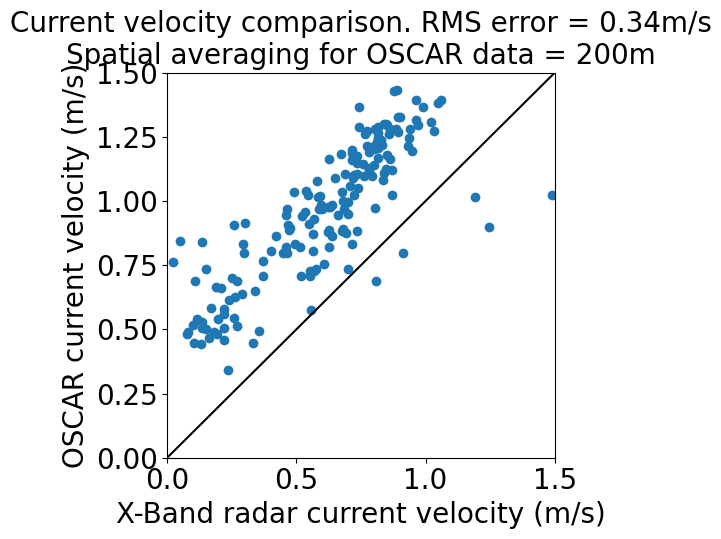

In [102]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(XbandCurrentVelocity,CurrentVelocityComparison)
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.plot([0,1.5],[0,1.5],'k')
plt.xlabel('X-Band radar current velocity (m/s)',fontsize=20)
plt.ylabel('OSCAR current velocity (m/s)',fontsize=20)

Uerr= np.sqrt(np.nanmean(XbandCurrentVelocity - CurrentVelocityComparison) **2 )
plt.title('Current velocity comparison. RMS error = '+str(round(Uerr,2))+'m/s\n'
         'Spatial averaging for OSCAR data = '+str(rolling_window * sar_pixel_size) +'m')
plt.show()
#np.sqrt(np.nanmean(ds_xband.CurrentDirection.values.flatten() - ds_L2[track].CurrentDirection.values.flatten()) **2 )

## Plot X-band direction vs OSCAR direction

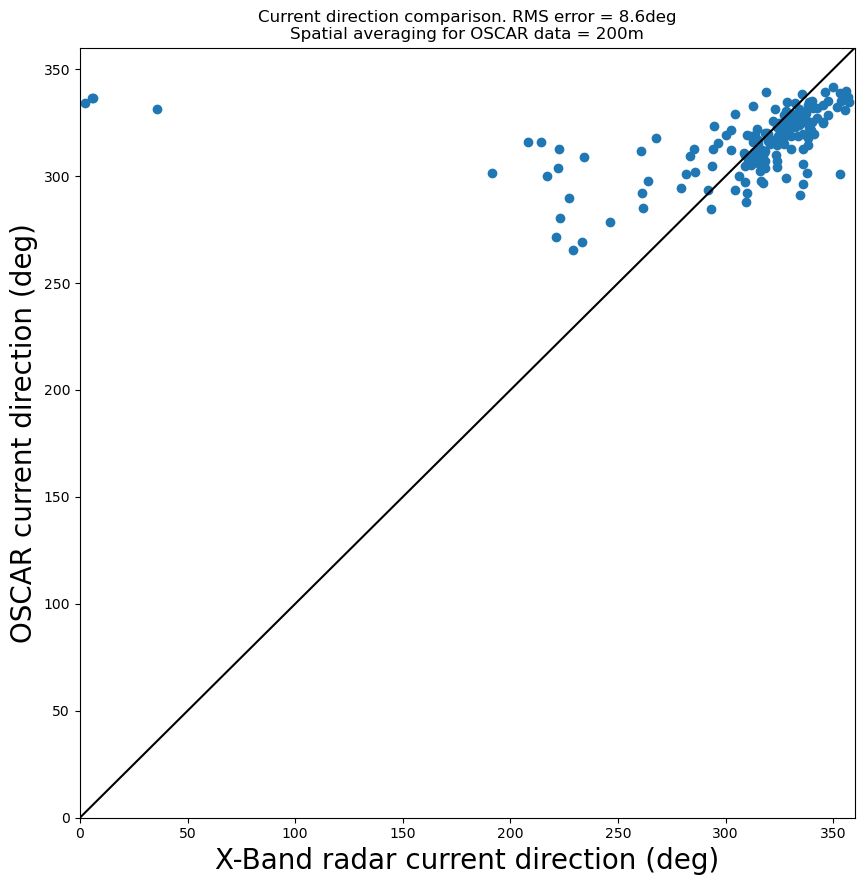

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(XbandCurrentDirection,CurrentDirectionComparison)
plt.xlim([0,360])
plt.ylim([0,360])
plt.plot([0,360],[0,360],'k')
plt.xlabel('X-Band radar current direction (deg)',fontsize=20)
plt.ylabel('OSCAR current direction (deg)',fontsize=20)

Derr= np.sqrt(np.nanmean(XbandCurrentDirection - CurrentDirectionComparison) **2 )
plt.title('Current direction comparison. RMS error = '+str(round(Derr,1))+'deg\n'
         'Spatial averaging for OSCAR data = '+str(rolling_window * sar_pixel_size) +'m')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(1,1,1)

ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
plt.plot(ds_xband.longitude_RADAR,ds_xband.latitude_RADAR, marker="^", color='r', markersize=20)
#ds_xband.plot.scatter(x='longitude_RADAR', y='latitude_RADAR',s=1000)
#ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True)

In [ ]:
track='Track_1'
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=ds_xband\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.CurrentVelocity.plot(
    y='latitude',x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ds_xband\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',y='latitude',
    u='Ux',v='Uy',
    scale=30,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
#ds_xband.plot.scatter(x='longitude_RADAR', y='latitude_RADAR')
plt.title('X-band derived surface currents \n 2022-05-17 \n Colocated on OSCAR grid')
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
#ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
ax.set_extent([-5.2, -5.025, 48.37, 48.5])
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

cbar = plt.colorbar(im)
cbar.set_label('Current velocity (m/s)',fontsize=30)
#plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=20)
#plt.show()

#SMALL_SIZE = 20
#MEDIUM_SIZE = 10
#BIGGER_SIZE = 12
#
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#plt.savefig(fig_folder + 'Xband_20220517_new.png', dpi=150, bbox_inches='tight')
#ax.set_xlabel('Latitude', fontsize=14)

In [ ]:
trim_factor = 1
fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=ds_xband\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(),
    gridsize=200,
    cmap='gist_yarg',
)

plt.xlim([200,360])
plt.ylim([200,360])
plt.plot([200,360],[200,360],'k')
#plt.axis('equal')
#plt.title('Derived surface currents')
plt.xlabel('X-band surface current direction (deg)',fontsize=20)
plt.ylabel('OSCAR surface current direction (deg)',fontsize=20)
plt.title('OSCAR / Xband \n'
          + 'Current Direction comparison '
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )

#ax.set(xticklabels=[])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.savefig(fig_folder + 'OSCAR_Xband_direction_comparison_new.png', dpi=150, bbox_inches='tight')

fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=ds_xband\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentVelocity.values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentVelocity.values.flatten(),
    gridsize=100,
    cmap='gist_yarg',
)

vmin=0
vmax=2

plt.xlim([vmin,vmax])
plt.ylim([vmin,vmax])
plt.plot([vmin,vmax],[vmin,vmax],'k')
#plt.axis('equal')
#plt.title('Derived surface currents')
plt.xlabel('X-band surface current velocity (m/s)',fontsize=20)
plt.ylabel('OSCAR retrieved surface current velocity (m/s)',fontsize=20)
plt.title('OSCAR / Xband \n'
          + 'Current Magnitude comparison '
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.savefig(fig_folder + 'OSCAR_Xband_magnitude_comparison_new.png', dpi=150, bbox_inches='tight')

In [ ]:
for beam in ['Fore','Aft']:
    im = ds_L1b[track]\
    .sel(Antenna=beam)\
    .RadialSurfaceCurrent\
    .plot(figsize=(30, 6),
          y='GroundRange',
          x='CrossRange',
          robust=True,
          cmap='coolwarm',
          add_colorbar=False,
          #vmin=-3,vmax=3
         )
    cbar = plt.colorbar(im)
    cbar.set_label('RSC (m/s)',fontsize=30)
    plt.xlabel('CrossRange (m)',fontsize=20)
    plt.ylabel('GroundRange (m)',fontsize=20)
    plt.title('OSCAR Retrieved Radial Surface Current \n'
              + 'Antenna = '
              + beam
              +'\n'
              + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
              +'\n'
              + 'Data version = ' + version
             )
    #plt.savefig(fig_folder + 'RSC_' + beam + '.png', dpi=150, bbox_inches='tight')

## Plot Retireved current velocity with vectors
### Arrow for aircraft direction and symbol for La Jument

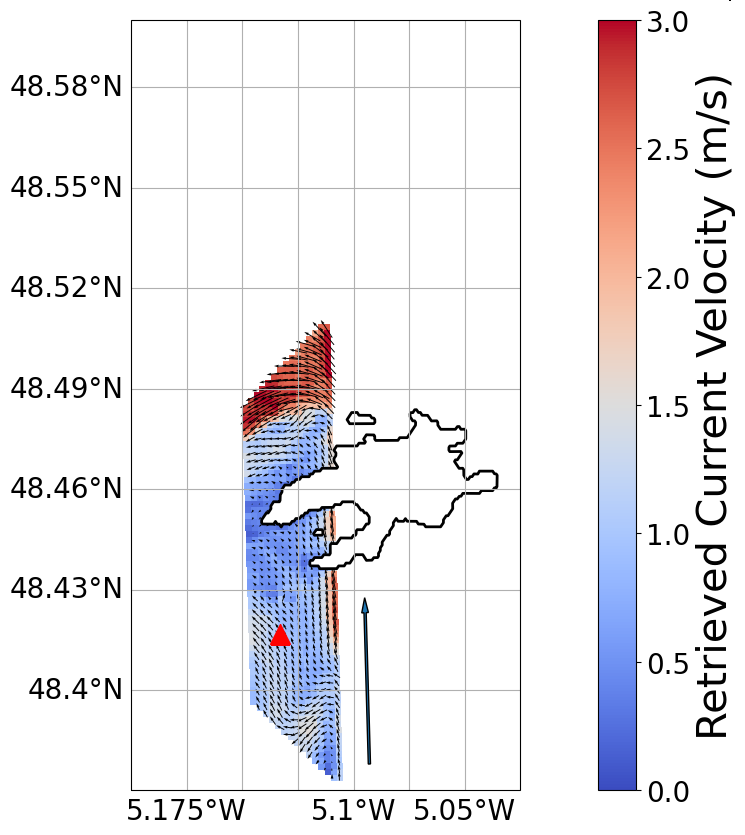

In [91]:
track='Track_1'
tracktime = str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor_image = int(plot_pixel_size / sar_pixel_size)
q_factor = 30 # Quiver plot scaling factor
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=ds_L2[track]\
.coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
.coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
.CurrentVelocity.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ds_L2[track]\
.coarsen(GroundRange=q_factor,boundary='trim').mean()\
.coarsen(CrossRange=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='CurrentVectorUComponent',
    v='CurrentVectorVComponent',
    scale=50,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
ax.set_extent([-5.2, -5.025, 48.37, 48.6], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
cbar = plt.colorbar(im)
cbar.set_label('Retrieved Current Velocity (m/s)',fontsize=30)
plt.plot(-5.13305, 48.4166, marker="^", color='r', markersize=15, transform=ccrs.PlateCarree())
x0 = ds_L2[track].longitude.isel(CrossRange=0, GroundRange=0)
y0 = ds_L2[track].latitude.isel(CrossRange=0, GroundRange=0)
dx = ds_L2[track].longitude.isel(CrossRange=-1, GroundRange=0) - ds_L2[track].longitude.isel(CrossRange=0, GroundRange=0)
dy = ds_L2[track].latitude.isel(CrossRange=-1, GroundRange=0) - ds_L2[track].latitude.isel(CrossRange=0, GroundRange=0)
x_shift = 0.01
y_shift = 0.05
ascale = 0.2

plt.arrow(x0 + x_shift,
          y0 + y_shift,
          dx*ascale,
          dy*ascale,
          transform=ccrs.PlateCarree(),
          zorder=10)
plt.show()



#plt.title('OSCAR Retrieved surface current velocity \n'
#              + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
#              +'\n'
#              + 'Data version = ' + version
#             )
#
#plt.savefig(fig_folder + 'OSCAR_RSC_20220517_new_transparent.png', dpi=150, bbox_inches='tight', transparent=True)
#plt.savefig(fig_folder + 'RSC_magnitude.png', dpi=150)
#ax.set_xlabel('Latitude', fontsize=14)

## Plot MARS2D current velocity with vectors

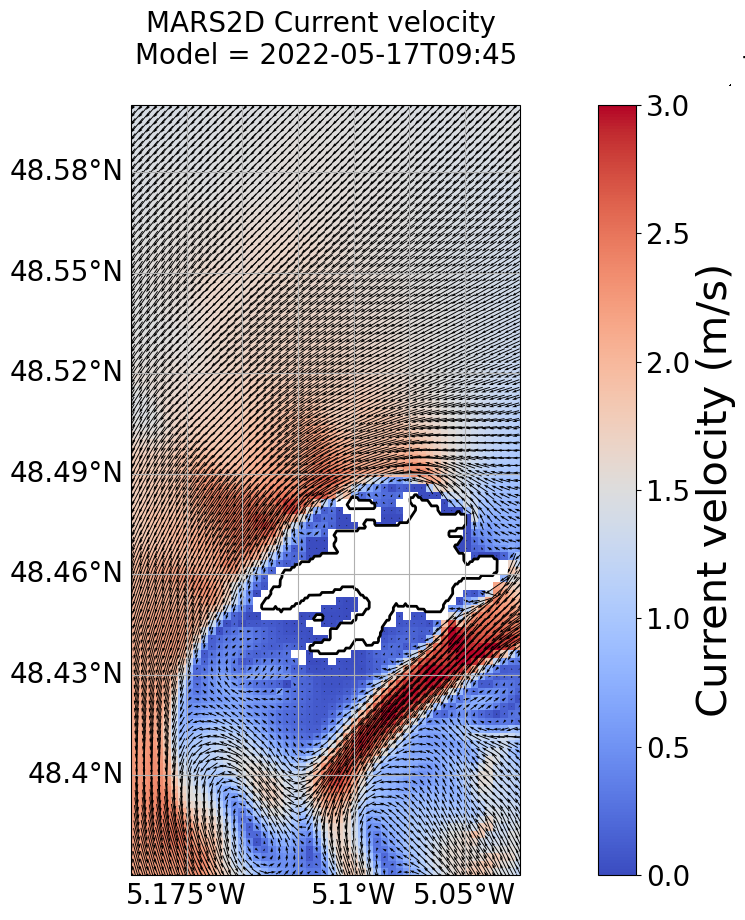

In [103]:
#track='Track_1'
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
q_factor = 30 # Quiver plot scaling factor
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
L1.CurrentVelocity\
.isel(time=timesel)\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
L1['U_coloc'], L1['V_coloc'] = ss.utils.tools.currentVelDir2UV(L1.CurrentVelocity,
                                                              L1.CurrentDirection)
L1\
.isel(time=timesel)\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='U_coloc',
    v='V_coloc',
    scale=30,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
plt.title('MARS2D')
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
ax.set_extent([-5.2, -5.025, 48.37, 48.6], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Current velocity (m/s)',fontsize=30)
#plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
#plt.show()

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.title('MARS2D Current velocity \n'
              + 'Model = ' + str(np.datetime64(L1.time.isel(time=timesel).data,'m')) +'\n'
             )

#plt.savefig(fig_folder + 'MARS2D_20220517.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
trim_factor = 1
fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=L1_CurrentMagnitude_colocated\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentMagnitude.values.flatten(),
    gridsize=200,
    cmap='gist_yarg',
)

vmin=0
vmax=2

plt.xlim([vmin,vmax])
plt.ylim([vmin,vmax])
plt.plot([vmin,vmax],[vmin,vmax],'k')

#plt.axis('equal')
plt.title('Surface currents comparison \n'
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )
plt.xlabel('MARS2D surface current magnitude (m/s)',fontsize=20)
plt.ylabel('OSCAR surface current magnitude (m/s)',fontsize=20)
#ax.set(xticklabels=[])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.savefig(fig_folder + 'OSCAR_MARS2D_magnitude_comparison.png', dpi=150, bbox_inches='tight')

fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=L1_CurrentDirection_colocated\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(),
    gridsize=200,
    cmap='gist_yarg',
)

vmin=200
vmax=360

plt.xlim([vmin,vmax])
plt.ylim([vmin,vmax])
plt.plot([vmin,vmax],[vmin,vmax],'k')
#plt.axis('equal')
plt.title('Surface currents comparison \n'
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )
plt.xlabel('MARS2D surface current direction (deg)',fontsize=20)
plt.ylabel('OSCAR surface current direction (deg)',fontsize=20)
#ax.set(xticklabels=[])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.savefig(fig_folder + 'OSCAR_MARS2D_direction_comparison_new.png', dpi=150, bbox_inches='tight')


In [ ]:
np.sqrt(np.nanmean(ds_xband.CurrentMagnitude.values.flatten() - ds_L2[track].CurrentMagnitude.values.flatten()) **2 )
#np.sqrt(np.nanmean(L1_CurrentDirection_colocated.values.flatten() - ds_L2[track].CurrentDirection.values.flatten()) **2 )

In [ ]:
track='Track_1'
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=(ds_L2[track].CurrentMagnitude-L1_CurrentMagnitude_colocated)\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
#L1\
#.isel(time=timesel)\
#.plot.quiver(
#    x='longitude',
#    y='latitude',
#    u='U_coloc',
#    v='V_coloc',
#    scale=30,
#    angles='xy',
#    robust=True,
#    transform=ccrs.PlateCarree()
#)

plt.title('Difference between OSCAR and MARS2D \n' 
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m')))

gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Current velocity (m/s)',fontsize=30)
#plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
#plt.show()

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.title('Difference between OSCAR RSC and MARS2D currents \n'
              + 'Track = ' + tracktime + '\n'
              + 'Model = ' + str(np.datetime64(L1.time.isel(time=timesel).data,'m')) +'\n'
              + 'Data version = ' + version
             )

plt.savefig(fig_folder + 'OSCAR_MARS2D_difference_20220517_new.png', dpi=150, bbox_inches='tight')


In [ ]:
def find_coordinate_origin(ds, coord):
    coord_origin = ds[coord][np.where(ds[coord] == np.min(np.abs(ds[coord])))]
    coord_origin = coord_origin.data
    return coord_origin


In [ ]:
def track_title_to_datetime(title):

    year = title.split()[2].split('T')[0][0:4]
    month = title.split()[2].split('T')[0][4:6]
    day = title.split()[2].split('T')[0][6:8]
    hour = title.split()[2].split('T')[1][0:2]
    minute = title.split()[2].split('T')[1][2:4]
    second = title.split()[2].split('T')[1][4:6]
    track_time = np.datetime64(year + '-' + month + '-' + day + 'T' + hour + ':' + minute + ':' + second)
    return track_time

In [ ]:
def merge_beams(ds_dict, antenna_id):

    ds_level1 = xr.concat(objs=list(ds_dict.values()),
                          dim='Antenna',
                          join='outer',
                          coords='all',
                         )
    
    ds_level1 = ds_level1.assign_coords(Antenna=('Antenna', antenna_id))
    #key_list = list(ds_dict.keys())
    #ds_level1.coords['latitude'] = xr.merge(
    #        [ds_dict[key_list[0]].LatImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[1]].LatImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[2]].LatImage.dropna(dim='CrossRange')],
    #        #compat='override',
    #        ).LatImage
    #ds_level1.coords['longitude'] = xr.merge(
    #        [ds_dict[key_list[0]].LonImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[1]].LonImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[2]].LonImage.dropna(dim='CrossRange')],
    #        #compat='override',
    #        ).LonImage

    return ds_level1

In [4]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    dswasv = seastar.gmfs.doppler.compute_wasv(level1,
                                               aux,
                                               gmf
                                               )
    
    if level1.Antenna =='Aft':
        rsc = -level1.RadialSurfaceVelocity - dswasv
    else:
        rsc = level1.RadialSurfaceVelocity - dswasv
    
    #rsv_list = [level1.RadialSurfaceVelocity.sel(Antenna=a)
    #            - dswasv.sel(Antenna=a)
    #            for a in list(level1.Antenna.data)
    #            ]
    #rsv_list[list(level1.Antenna.data).index('Aft')] = \
    #-level1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv.sel(Antenna='Aft')
    #level1['RadialSurfaceCurrent'] = xr.concat(rsv_list,
    #                                           'Antenna',
    #                                           join='outer')
    #level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent\
    #    .assign_coords(Antenna=('Antenna',
    #                            list(level1.Antenna.data)
    #                            )
    #                   )
    #level1.RadialSurfaceCurrent.attrs['long_name'] =\
    #    'Radial Surface Current (RSC) along antenna beam direction, corrected'\
    #    'for Wind Artifact Surface Velocity (WASV)'
    #level1.RadialSurfaceCurrent.attrs['units'] = '[m/s]'

    return rsc

In [ ]:
 if ds_L1b['Track_1'].sel(Antenna='Fore').Antenna =='Fore':
        print('hello')

In [ ]:
def shift_coordinate_origin(ds_dict, coord):

    origins=np.full((len(ds_dict),1),0.0)
    
    for beam in ds_dict.keys():
        origins[list(ds_dict.keys()).index(beam)] = ds_dict[beam][coord].sel(CrossRange=0).isel(GroundRange=0).data
    
    origins_diff = np.diff(origins, axis=0)
    origins_diff = np.insert(origins_diff, 0, 0)
    for beam in ds_dict.keys():
        ds_dict[beam][coord] = ds_dict[beam][coord] - origins_diff[list(ds_dict.keys()).index(beam)]
    return ds_dict

In [ ]:
def fill_missing_variables(ds_dict, antenna_id):

    fore_id = list(ds_dict.keys())[antenna_id.index('Fore')]
    mid_id = list(ds_dict.keys())[antenna_id.index('Mid')]
    aft_id = list(ds_dict.keys())[antenna_id.index('Aft')]
    # Find vars that dont exist in Mid , but exist in Fore
    for var in ds_dict[fore_id].data_vars:
        if var not in ds_dict[mid_id].data_vars:
            var_shape = (
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[0]]),
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[1]]))
            ds_dict[mid_id][var] = xr.DataArray(
                data=np.full(var_shape, np.NaN),
                coords=ds_dict[mid_id].coords,
                dims=ds_dict[mid_id].dims)
    # Find vars that dont exist in Fore for Aft , but exist in Mid
    for var in ds_dict[mid_id].data_vars:
        for antenna in [fore_id, aft_id]:
            if var not in ds_dict[antenna].data_vars:
                ds_dict[antenna][var] = xr.DataArray(
                    data=np.full(ds_dict[mid_id][var].shape, np.NaN),
                    coords=ds_dict[mid_id][var].coords,
                    dims=ds_dict[mid_id][var].dims)

    return ds_dict

In [ ]:
def readGeotiff(image_file_path):
    ## read the image using gdal
    try:        
        image_dataset_gdal = gdal.Open(image_file_path, gdal.GA_ReadOnly)
        geotransform = image_dataset_gdal.GetGeoTransform()        
        image_np = image_dataset_gdal.ReadAsArray()    
    except:        
        raise Exception(f'WARNING image file could not be read: {image_file_path}')    
    if len(image_np.shape) == 2:        
        image_np = np.expand_dims(image_np, axis=0)    
    cell_size = (abs(geotransform[1]) + abs(geotransform[5])) / 2   
    
    return image_np, cell_size

In [ ]:
sar_file = 'D:\\data\SEASTAR\\SAR\\NovaSAR\\NovaSAR_01_33889_Ground_Range_Multilook_Detected_13_220517_103020_VV\\image_VV.tif'
image_dataset_gdal = gdal.Open(sar_file, gdal.GA_ReadOnly)
geotransform = image_dataset_gdal.GetGeoTransform()        
image_np = image_dataset_gdal.ReadAsArray()  


In [ ]:
image_dataset = gdal.Open(sar_file)
image_dataset.GetProjection()

In [ ]:
from osgeo import gdal

In [ ]:

image, cell_size = readGeotiff('D:\\data\SEASTAR\\SAR\\NovaSAR\\NovaSAR_01_33889_Ground_Range_Multilook_Detected_13_220517_103020_VV\\image_VV.tif')

In [ ]:
ds=ds_L1b[track].sel(Antenna='Aft')

ds = ds[['CrossRange','GroundRange','latitude','longitude','Intensity']]
ds = ds.drop_vars('Antenna')
ds['longitude_RADAR'] = ds_xband.longitude_RADAR
ds['latitude_RADAR'] = ds_xband.latitude_RADAR
ds

In [ ]:
ds.Intensity.plot(
    x='longitude',y='latitude',
    vmin=0,vmax=0.5,
    cmap='Greys')
plt.plot(ds_xband.longitude_RADAR,ds_xband.latitude_RADAR, marker="^", color='r', markersize=1)





In [ ]:
savepath="D:\\data\\SEASTAR\\SEASTARex\\Data\\Hereon\\for_Ruben\\LaJumentImage.nc"
ds.to_netcdf(path=savepath)

In [ ]:
ds=xr.open_dataset(savepath)

In [ ]:
ds